# Fit data

Fit Gaussian Process model to crime data over London

In [131]:
import arviz as az
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as tt
import seaborn as sns

from bokeh.io import output_notebook
from bokeh.models import BoxAnnotation, Label, Legend, Span
from bokeh.palettes import brewer
from bokeh.plotting import figure, show

from calendar import monthrange

In [81]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [9]:
df = pd.read_pickle("mps.borough.crime.2010-2021.pickle").rename(columns={'LookUp_BoroughName': 'borough'}).drop('index',axis=1)
df['month'] = pd.DatetimeIndex(df['date']).month
df['year'] = pd.DatetimeIndex(df['date']).year
df

,MajorText,MinorText,borough,yearmonth,value,date,month,year
0,Arson and Criminal Damage,Arson,Barking and Dagenham,201004,6,2010-04-01,4,2010
1,Arson and Criminal Damage,Criminal Damage,Barking and Dagenham,201004,208,2010-04-01,4,2010
2,Burglary,Burglary Business and Community,Barking and Dagenham,201004,49,2010-04-01,4,2010
3,Burglary,Domestic Burglary,Barking and Dagenham,201004,118,2010-04-01,4,2010
4,Drug Offences,Drug Trafficking,Barking and Dagenham,201004,9,2010-04-01,4,2010
...,...,...,...,...,...,...,...,...
243403,Vehicle Offences,Theft from a Motor Vehicle,Westminster,202203,290,2022-03-01,3,2022
243404,Vehicle Offences,Theft or Taking of a Motor Vehicle,Westminster,202203,51,2022-03-01,3,2022
243405,Violence Against the Person,Homicide,Westminster,202203,0,2022-03-01,3,2022
243406,Violence Against the Person,Violence with Injury,Westminster,202203,347,2022-03-01,3,2022


In [14]:
np.unique(df.year)

array([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020,
       2021, 2022])

In [44]:
def dates_to_idx(timelist):
    reference_time = pd.to_datetime("2010-01-01").date()
    t = (timelist - reference_time) / pd.Timedelta(365, "D")
    return np.asarray(t)

# Make decimal dates
t = dates_to_idx(df.date.values)

df = df.assign(t=t)
df

,MajorText,MinorText,borough,yearmonth,value,date,month,year,t
0,Arson and Criminal Damage,Arson,Barking and Dagenham,201004,6,2010-04-01,4,2010,0.246575
1,Arson and Criminal Damage,Criminal Damage,Barking and Dagenham,201004,208,2010-04-01,4,2010,0.246575
2,Burglary,Burglary Business and Community,Barking and Dagenham,201004,49,2010-04-01,4,2010,0.246575
3,Burglary,Domestic Burglary,Barking and Dagenham,201004,118,2010-04-01,4,2010,0.246575
4,Drug Offences,Drug Trafficking,Barking and Dagenham,201004,9,2010-04-01,4,2010,0.246575
...,...,...,...,...,...,...,...,...,...
243403,Vehicle Offences,Theft from a Motor Vehicle,Westminster,202203,290,2022-03-01,3,2022,12.169863
243404,Vehicle Offences,Theft or Taking of a Motor Vehicle,Westminster,202203,51,2022-03-01,3,2022,12.169863
243405,Violence Against the Person,Homicide,Westminster,202203,0,2022-03-01,3,2022,12.169863
243406,Violence Against the Person,Violence with Injury,Westminster,202203,347,2022-03-01,3,2022,12.169863


In [72]:
df = df.assign(dayinmonth = list(map(lambda x: monthrange(x.year, x.month)[1], df.date)))
df.value / df.dayinmonth

0          0.200000
1          6.933333
2          1.633333
3          3.933333
4          0.300000
            ...    
243403     9.354839
243404     1.645161
243405     0.000000
243406    11.193548
243407    21.258065
Length: 243408, dtype: float64

In [233]:
df['crime/day'] = df['value'] / df['dayinmonth']
df

,MajorText,MinorText,borough,yearmonth,value,date,month,year,t,dayinmonth,crime/day
0,Arson and Criminal Damage,Arson,Barking and Dagenham,201004,6,2010-04-01,4,2010,0.246575,30,0.200000
1,Arson and Criminal Damage,Criminal Damage,Barking and Dagenham,201004,208,2010-04-01,4,2010,0.246575,30,6.933333
2,Burglary,Burglary Business and Community,Barking and Dagenham,201004,49,2010-04-01,4,2010,0.246575,30,1.633333
3,Burglary,Domestic Burglary,Barking and Dagenham,201004,118,2010-04-01,4,2010,0.246575,30,3.933333
4,Drug Offences,Drug Trafficking,Barking and Dagenham,201004,9,2010-04-01,4,2010,0.246575,30,0.300000
...,...,...,...,...,...,...,...,...,...,...,...
243403,Vehicle Offences,Theft from a Motor Vehicle,Westminster,202203,290,2022-03-01,3,2022,12.169863,31,9.354839
243404,Vehicle Offences,Theft or Taking of a Motor Vehicle,Westminster,202203,51,2022-03-01,3,2022,12.169863,31,1.645161
243405,Violence Against the Person,Homicide,Westminster,202203,0,2022-03-01,3,2022,12.169863,31,0.000000
243406,Violence Against the Person,Violence with Injury,Westminster,202203,347,2022-03-01,3,2022,12.169863,31,11.193548


In [276]:
sdf = df[(df.MajorText == 'Public Order Offences') & (df.borough == 'Westminster')]
sdf

,MajorText,MinorText,borough,yearmonth,value,date,month,year,t,dayinmonth,crime/day
1700,Public Order Offences,"Other Offences Against the State, or Public Order",Westminster,201004,30,2010-04-01,4,2010,0.246575,30,1.000000
1701,Public Order Offences,Public Fear Alarm or Distress,Westminster,201004,109,2010-04-01,4,2010,0.246575,30,3.633333
1702,Public Order Offences,Racially or Religiously Aggravated Public Fear...,Westminster,201004,6,2010-04-01,4,2010,0.246575,30,0.200000
1703,Public Order Offences,Violent Disorder,Westminster,201004,2,2010-04-01,4,2010,0.246575,30,0.066667
3419,Public Order Offences,"Other Offences Against the State, or Public Order",Westminster,201005,27,2010-05-01,5,2010,0.328767,31,0.870968
...,...,...,...,...,...,...,...,...,...,...,...
241845,Public Order Offences,Violent Disorder,Westminster,202202,0,2022-02-01,2,2022,12.093151,28,0.000000
243389,Public Order Offences,"Other Offences Against the State, or Public Order",Westminster,202203,29,2022-03-01,3,2022,12.169863,31,0.935484
243390,Public Order Offences,Public Fear Alarm or Distress,Westminster,202203,175,2022-03-01,3,2022,12.169863,31,5.645161
243391,Public Order Offences,Racially or Religiously Aggravated Public Fear...,Westminster,202203,90,2022-03-01,3,2022,12.169863,31,2.903226


<AxesSubplot:xlabel='date', ylabel='crime/day'>

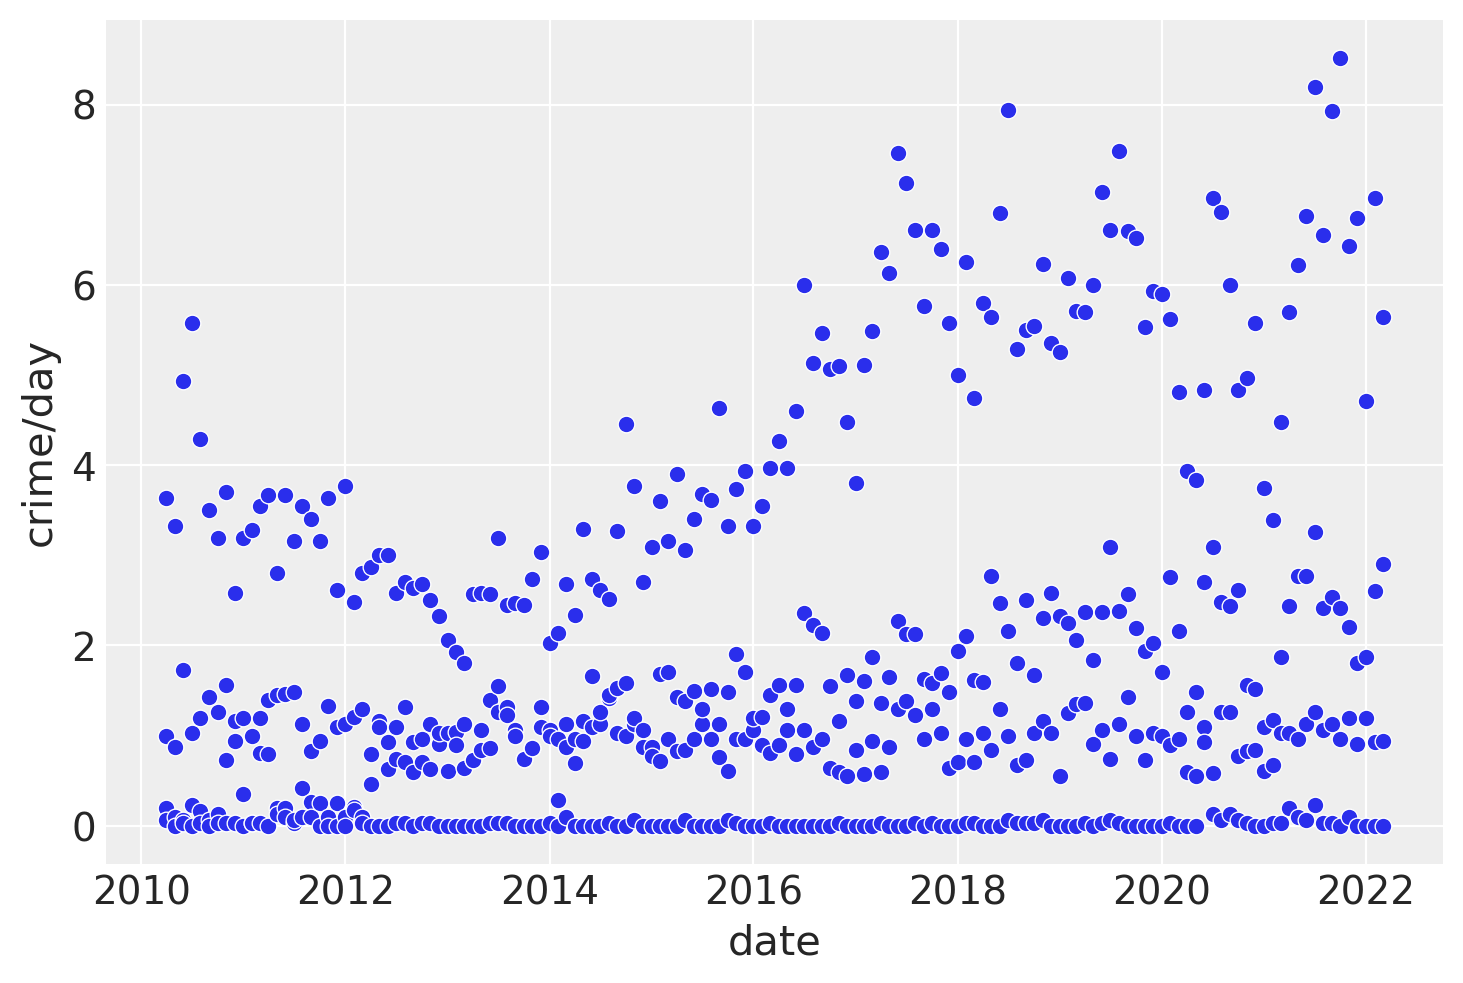

In [284]:
sns.scatterplot(data=sdf, x='date', y='crime/day')

## Build GP model

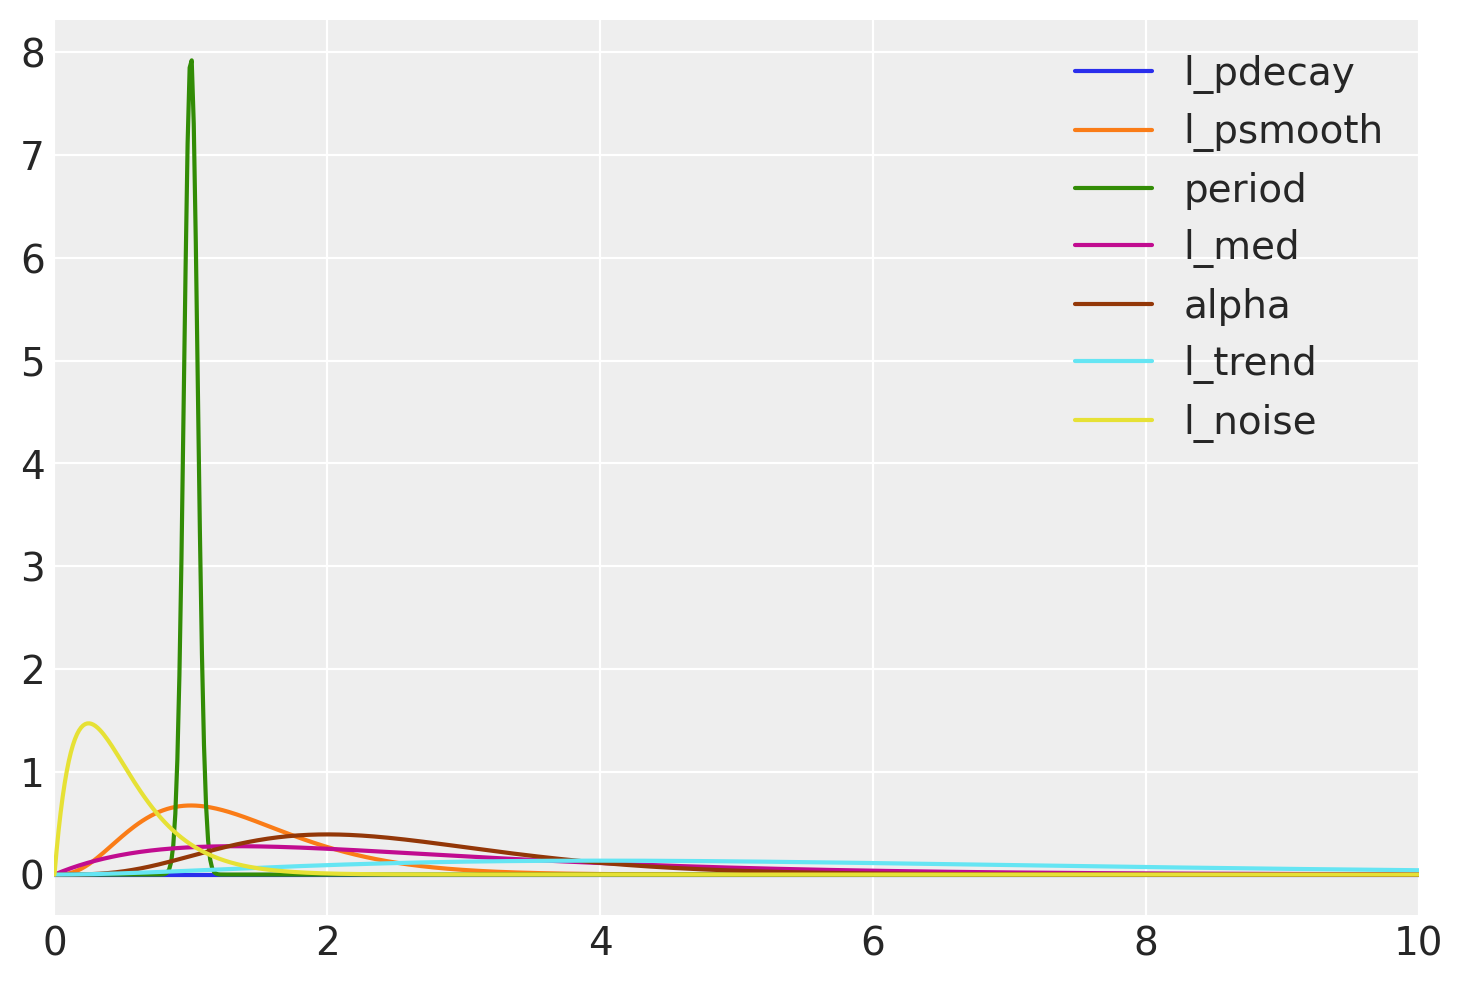

In [104]:
x = np.linspace(0, 15, 1000)
priors = [
    ("l_pdecay", pm.Gamma.dist(alpha=10, beta=0.075)),
    ("l_psmooth", pm.Gamma.dist(alpha=4, beta=3)),
    ("period", pm.Normal.dist(mu=1.0, sigma=0.05)),
    ("l_med", pm.Gamma.dist(alpha=2, beta=0.75)),
    ("alpha", pm.Gamma.dist(alpha=5, beta=2)),
    ("l_trend", pm.Gamma.dist(alpha=3, beta=0.5)),
    ("l_noise", pm.Gamma.dist(alpha=2, beta=4)),
]

for i, prior in enumerate(priors):
    plt.plot(
        x,
        np.exp(prior[1].logp(x).eval()),
        label=prior[0]
    )

plt.xlim([0, 10])
plt.legend()
plt.show(p)

* `l_pdecay`: The periodic decay. The smaller this parameter is, the faster the periodicity goes away. I doubt that the seasonality of the crime will be going away any time soon, and there’s no evidence for that in the data. Most of the prior mass is from 60 to >140 years.

* `l_psmooth`: The smoothness of the periodic component. It controls how “sinusoidal” the periodicity is. The plot of the data shows that seasonality is not an exact sine wave, but its not terribly different from one. We use a Gamma whose mode is at one, and doesn’t have too large of a variance, with most of the prior mass from around 0.5 and 2.

* `period`: The period. We put a very strong prior on, the period that is centered at one. R+W fix, since the period is annual.

* `l_med`: This is the lengthscale for the short to medium long variations. This prior has most of its mass below 6 years.

* `alpha`: This is the shape parameter. This prior is centered at 3, since we’re expecting there to be some more variation than could be explained by an exponentiated quadratic.

* `l_trend`: The lengthscale of the long term trend. It has a wide prior with mass on a 2-year scale. Most of the mass is between 2 to 6 years.

* `l_noise`: The lengthscale of the noise covariance. This noise should be very rapid, in the scale of several months to at most a year or two.

For all of the scale priors we use distributions that shrink the scale towards zero. The seasonal component and the long term trend have the least mass near zero, since they are the largest influences in the data.

* `eta_per`: Scale of the periodic or seasonal component.

* `eta_med`: Scale of the short to medium term component.

* `eta_trend`: Scale of the long term trend.

* `sigma`: Scale of the white noise.

* `eta_noise`: Scale of correlated, short term noise.


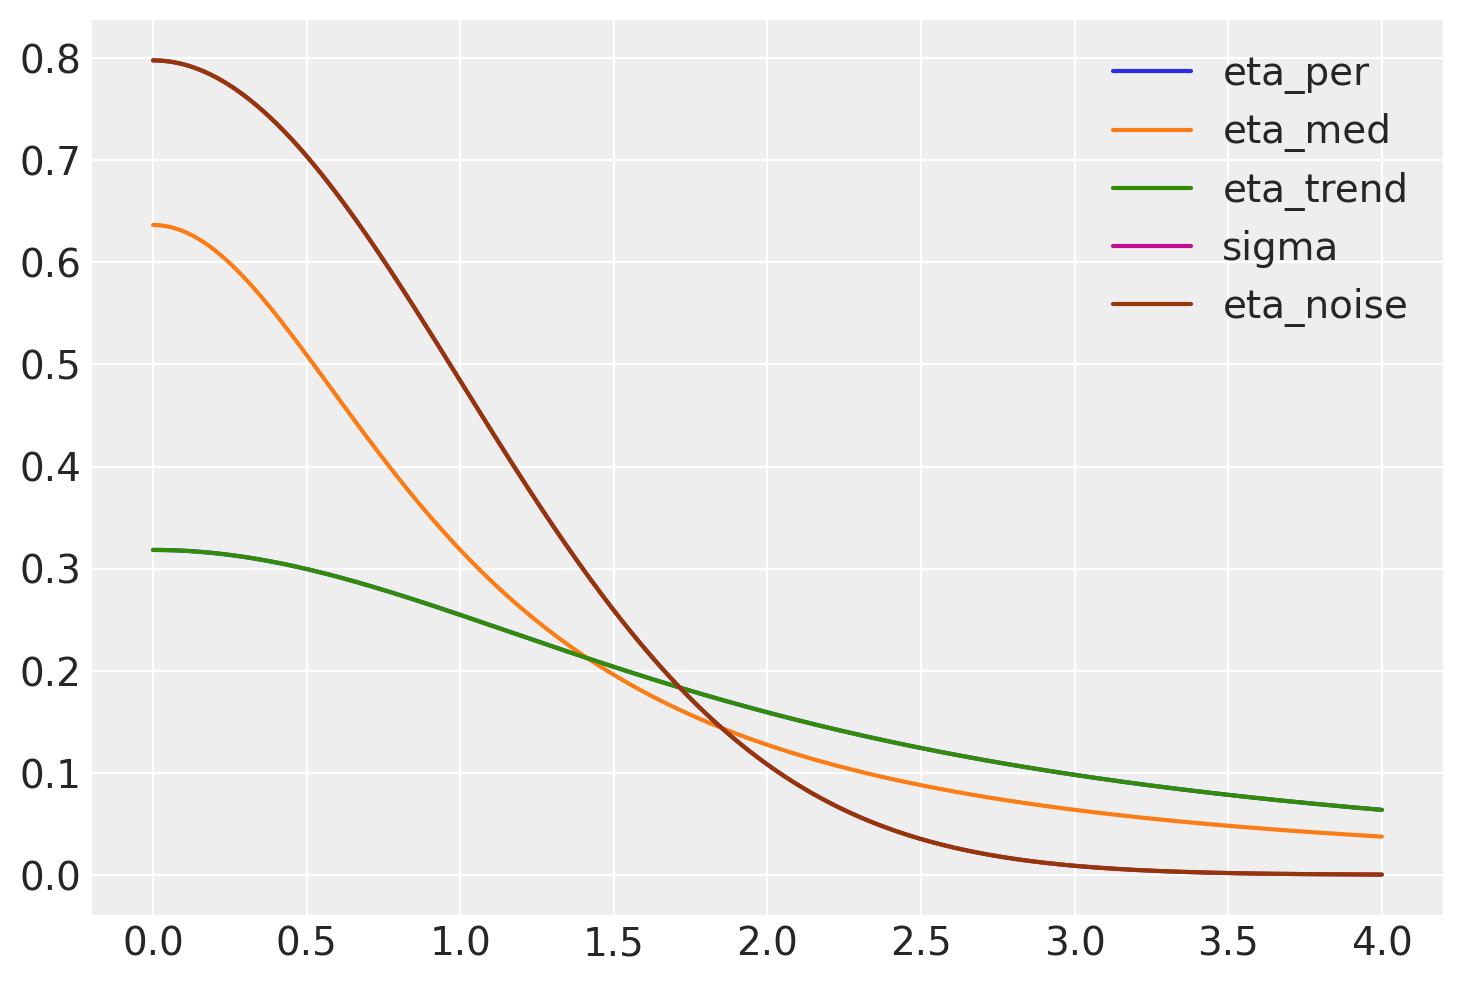

In [198]:
x = np.linspace(0, 4, 5000)
priors = [
    ("eta_per", pm.HalfCauchy.dist(beta=2)),
    ("eta_med", pm.HalfCauchy.dist(beta=1.0)),
    ("eta_trend", pm.HalfCauchy.dist(beta=2)),  # will use beta=2, but 2.2 is visible on plot
    ("sigma", pm.HalfNormal.dist(sigma=1)),
    ("eta_noise", pm.HalfNormal.dist(sigma=1))
]

for i, prior in enumerate(priors):
    plt.plot(
        x,
        np.exp(prior[1].logp(x).eval()),
        label=prior[0]
    )

plt.legend()
plt.show()

In [277]:
# pull out normalized data
t = sdf["t"].values[:, None]
y = sdf["crime/day"].values
y_mean = y.mean()
y_std = y.std()

y_r = y/y_mean

sdf = sdf.assign(y_r=y_r)
sdf

,MajorText,MinorText,borough,yearmonth,value,date,month,year,t,dayinmonth,crime/day,y_r
1700,Public Order Offences,"Other Offences Against the State, or Public Order",Westminster,201004,30,2010-04-01,4,2010,0.246575,30,1.000000,0.574352
1701,Public Order Offences,Public Fear Alarm or Distress,Westminster,201004,109,2010-04-01,4,2010,0.246575,30,3.633333,2.086812
1702,Public Order Offences,Racially or Religiously Aggravated Public Fear...,Westminster,201004,6,2010-04-01,4,2010,0.246575,30,0.200000,0.114870
1703,Public Order Offences,Violent Disorder,Westminster,201004,2,2010-04-01,4,2010,0.246575,30,0.066667,0.038290
3419,Public Order Offences,"Other Offences Against the State, or Public Order",Westminster,201005,27,2010-05-01,5,2010,0.328767,31,0.870968,0.500242
...,...,...,...,...,...,...,...,...,...,...,...,...
241845,Public Order Offences,Violent Disorder,Westminster,202202,0,2022-02-01,2,2022,12.093151,28,0.000000,0.000000
243389,Public Order Offences,"Other Offences Against the State, or Public Order",Westminster,202203,29,2022-03-01,3,2022,12.169863,31,0.935484,0.537297
243390,Public Order Offences,Public Fear Alarm or Distress,Westminster,202203,175,2022-03-01,3,2022,12.169863,31,5.645161,3.242309
243391,Public Order Offences,Racially or Religiously Aggravated Public Fear...,Westminster,202203,90,2022-03-01,3,2022,12.169863,31,2.903226,1.667473


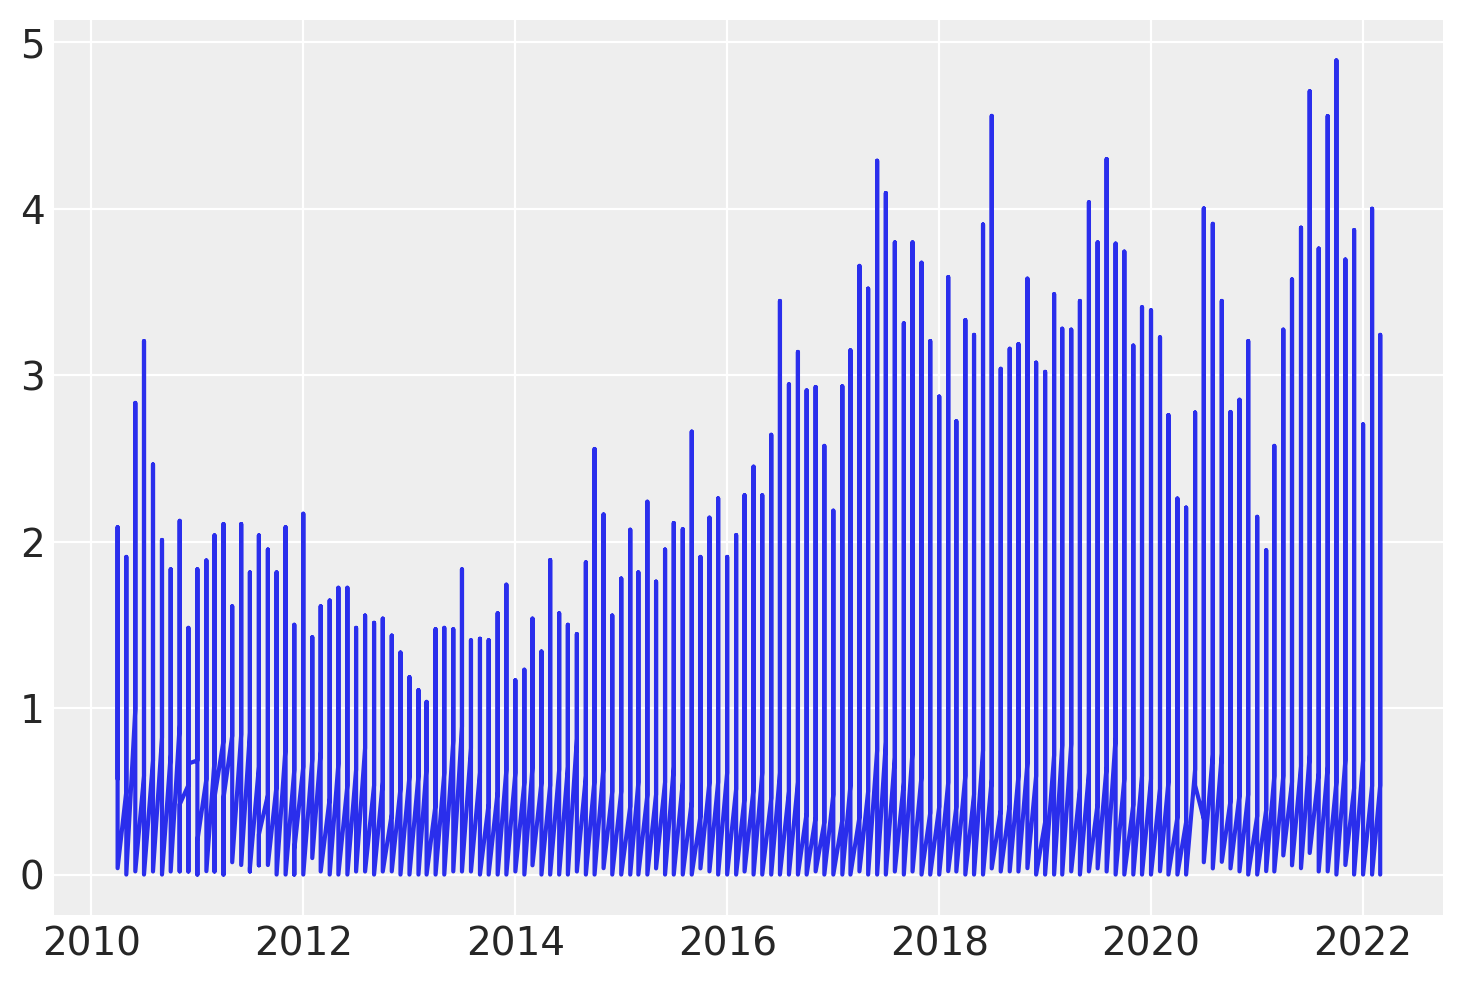

In [282]:
plt.plot(sdf.date, sdf.y_r)

In [285]:
with pm.Model() as model:
    # yearly periodic component x long term trend
    eta_per = pm.HalfCauchy("eta_per", beta=2, testval=1.0)
    l_pdecay = pm.Gamma("l_pdecay", alpha=10, beta=0.075)
    period = pm.Normal("period", mu=1, sigma=0.2)
    l_psmooth = pm.Gamma("l_psmooth ", alpha=4, beta=3)
    cov_seasonal = (eta_per ** 2 * pm.gp.cov.Periodic(1, period, l_psmooth) * pm.gp.cov.Matern52(1, l_pdecay))
    gp_seasonal = pm.gp.Marginal(cov_func=cov_seasonal)

    # small/medium term irregularities
    eta_med = pm.HalfCauchy("eta_med", beta=0.5, testval=0.1)
    l_med = pm.Gamma("l_med", alpha=2, beta=0.75)
    alpha = pm.Gamma("alpha", alpha=5, beta=2)
    cov_medium = eta_med ** 2 * pm.gp.cov.RatQuad(1, l_med, alpha)
    gp_medium = pm.gp.Marginal(cov_func=cov_medium)

    # long term trend
    eta_trend = pm.HalfCauchy("eta_trend", beta=2, testval=2.0)
    l_trend = pm.Gamma("l_trend", alpha=3, beta=0.5)
    cov_trend = eta_trend ** 2 * pm.gp.cov.ExpQuad(1, l_trend)
    gp_trend = pm.gp.Marginal(cov_func=cov_trend)

    # noise model
    eta_noise = pm.HalfNormal("eta_noise", sigma=0.5, testval=0.05)
    l_noise = pm.Gamma("l_noise", alpha=2, beta=4)
    sigma = pm.HalfNormal("sigma", sigma=0.25, testval=0.05)
    cov_noise = eta_noise ** 2 * pm.gp.cov.Matern32(1, l_noise) + pm.gp.cov.WhiteNoise(sigma)

    # The Gaussian process is a sum of these three components
    gp = gp_seasonal + gp_medium + gp_trend

    # p = pm.Beta("p", alpha=1, beta=1)
    # Since the normal noise model and the GP are conjugates, we use `Marginal` with the `.marginal_likelihood` method
    y_ = gp.marginal_likelihood("y", X=t, y=y_r, noise=cov_noise)
    # likelihood = pm.ZeroInflatedPoisson("likelihood", psi=p, theta=tt.exp(gp), observed=y_n)

    # this line calls an optimizer to find the MAP
    mp = pm.find_MAP(include_transformed=True)

In [227]:
gp

In [267]:
sorted([name + ":" + str(mp[name]) for name in mp.keys() if not name.endswith("_")])

['alpha:1.9952514278076374',
 'eta_med:0.0013100999292967117',
 'eta_noise:5.2359502419292874e-05',
 'eta_per:0.22969773945962751',
 'eta_trend:1.2293646954905306',
 'l_med:1.329541057215351',
 'l_noise:0.2497298978263283',
 'l_pdecay:119.99043303546102',
 'l_psmooth :1.063059250131924',
 'l_trend:5.8427686908261265',
 'period:1.0066411535972994',
 'sigma:1.633351563335036']

In [292]:
# predict at a 15 day granularity
dates = pd.date_range(start="01/01/2010", end="31/12/2025", freq="1W")
tnew = dates_to_idx(dates.date)[:, None]

print("Predicting with gp ...")
mu, var = gp.predict(tnew, point=mp, diag=True)
mean_pred = mu * yt_mean
var_pred = var * yt_std ** 2

# make dataframe to store fit results
fit = pd.DataFrame(
    {"t": tnew.flatten(), "mu_total": mean_pred, "sd_total": np.sqrt(var_pred)},
    index=dates,
)

print("Predicting with gp_trend ...")
mu, var = gp_trend.predict(tnew, point=mp, given={"gp": gp, "X": t, "y": y, "noise": cov_noise}, diag=True)
fit = fit.assign(mu_trend=mu * y_mean, sd_trend=np.sqrt(var * y_std ** 2))

print("Predicting with gp_medium ...")
mu, var = gp_medium.predict(tnew, point=mp, given={"gp": gp, "X": t, "y": y, "noise": cov_noise}, diag=True)
fit = fit.assign(mu_medium=mu * y_mean, sd_medium=np.sqrt(var * y_std ** 2))

print("Predicting with gp_seasonal ...")
mu, var = gp_seasonal.predict(tnew, point=mp, given={"gp": gp, "X": t, "y": y, "noise": cov_noise}, diag=True)
fit = fit.assign(mu_seasonal=mu * y_mean, sd_seasonal=np.sqrt(var * y_std ** 2))
print("Done")

Predicting with gp ...
Predicting with gp_trend ...
Predicting with gp_medium ...
Predicting with gp_seasonal ...
Done


In [288]:
fit

,t,mu_total,sd_total,mu_trend,sd_trend,mu_medium,sd_medium,mu_seasonal,sd_seasonal
2010-01-03,0.005479,2.402814,0.115165,3.830112,0.348002,1.741136,0.004361,1.691681,0.244962
2010-01-10,0.024658,2.402988,0.114325,3.828518,0.346533,1.741136,0.004361,1.693519,0.244959
2010-01-17,0.043836,2.404999,0.113472,3.826934,0.345080,1.741136,0.004361,1.697918,0.244958
2010-01-24,0.063014,2.408828,0.112609,3.825362,0.343641,1.741136,0.004361,1.704847,0.244959
2010-01-31,0.082192,2.414431,0.111735,3.823802,0.342218,1.741136,0.004361,1.714240,0.244961
...,...,...,...,...,...,...,...,...,...
2025-11-30,15.923288,3.062907,0.314418,4.593836,0.796337,1.741101,0.004361,1.796327,0.245059
2025-12-07,15.942466,3.040584,0.315578,4.585182,0.799243,1.741101,0.004361,1.777244,0.245064
2025-12-14,15.961644,3.019467,0.316749,4.576525,0.802148,1.741101,0.004361,1.759568,0.245068
2025-12-21,15.980822,2.999723,0.317932,4.567865,0.805053,1.741101,0.004361,1.743522,0.245071


<AxesSubplot:xlabel='t', ylabel='y_r'>

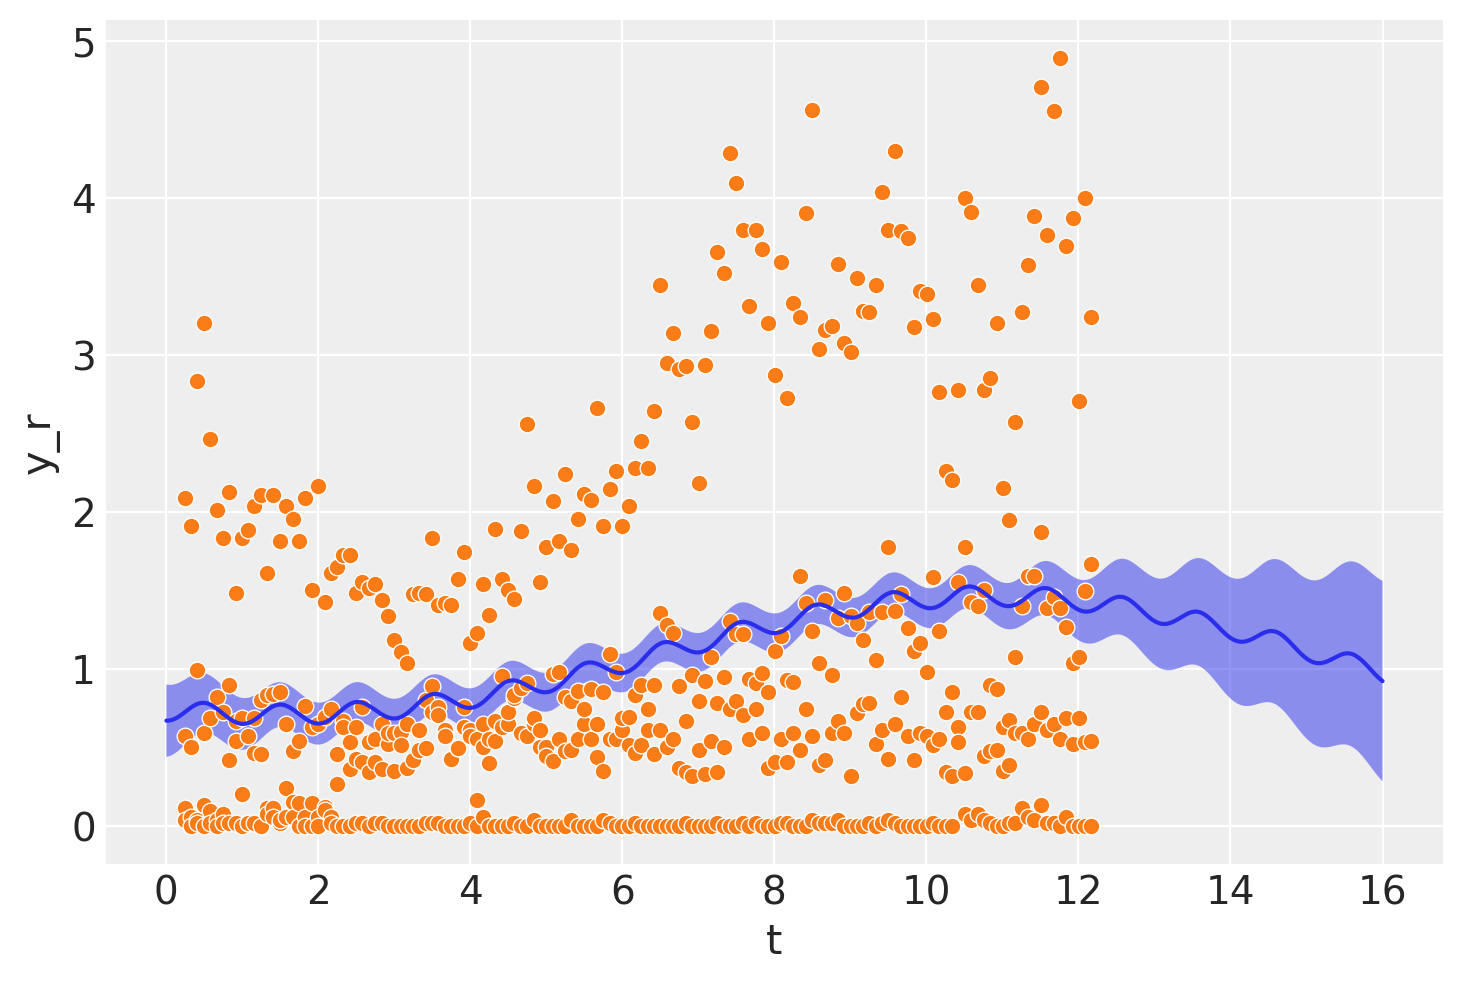

In [293]:
upper = fit.mu_total + 2 * fit.sd_total
lower = fit.mu_total - 2 * fit.sd_total
band_x = np.append(fit.t.values, fit.t.values[::-1])
band_y = np.append(lower, upper[::-1])

fig, ax = plt.subplots()
ax.plot(fit.t, fit.mu_total)
ax.fill_between(band_x, band_y, alpha=0.5)
sns.scatterplot(data=sdf, x='t', y='y_r', ax=ax)

<AxesSubplot:xlabel='t', ylabel='mu_trend'>

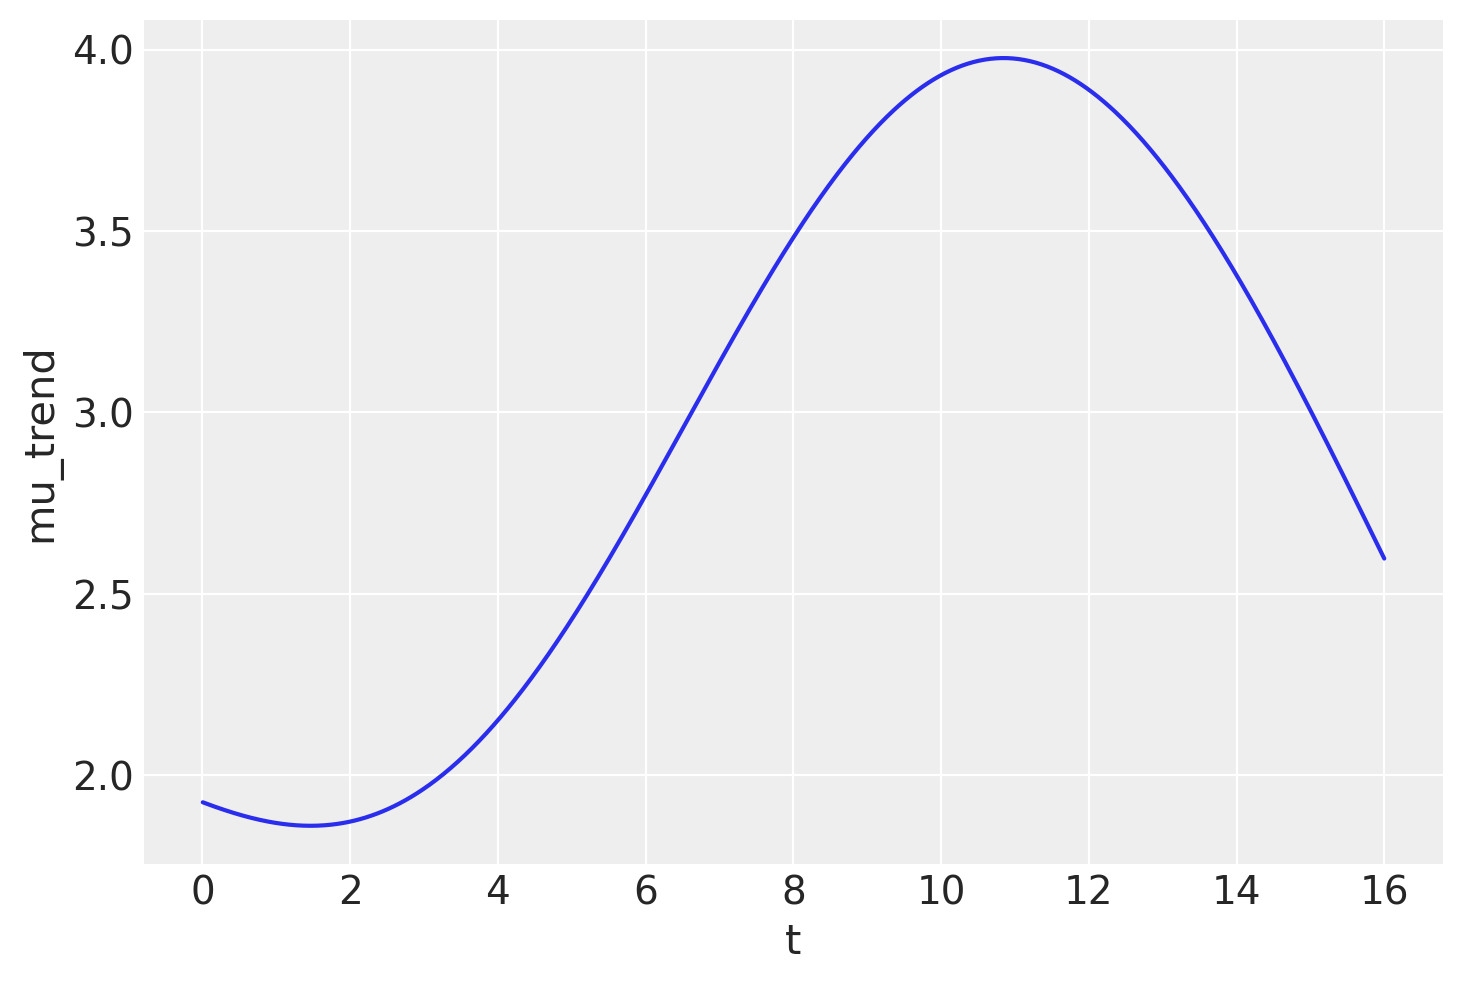

In [294]:
sns.lineplot(data=fit, y='mu_trend', x='t')

<AxesSubplot:xlabel='t', ylabel='mu_seasonal'>

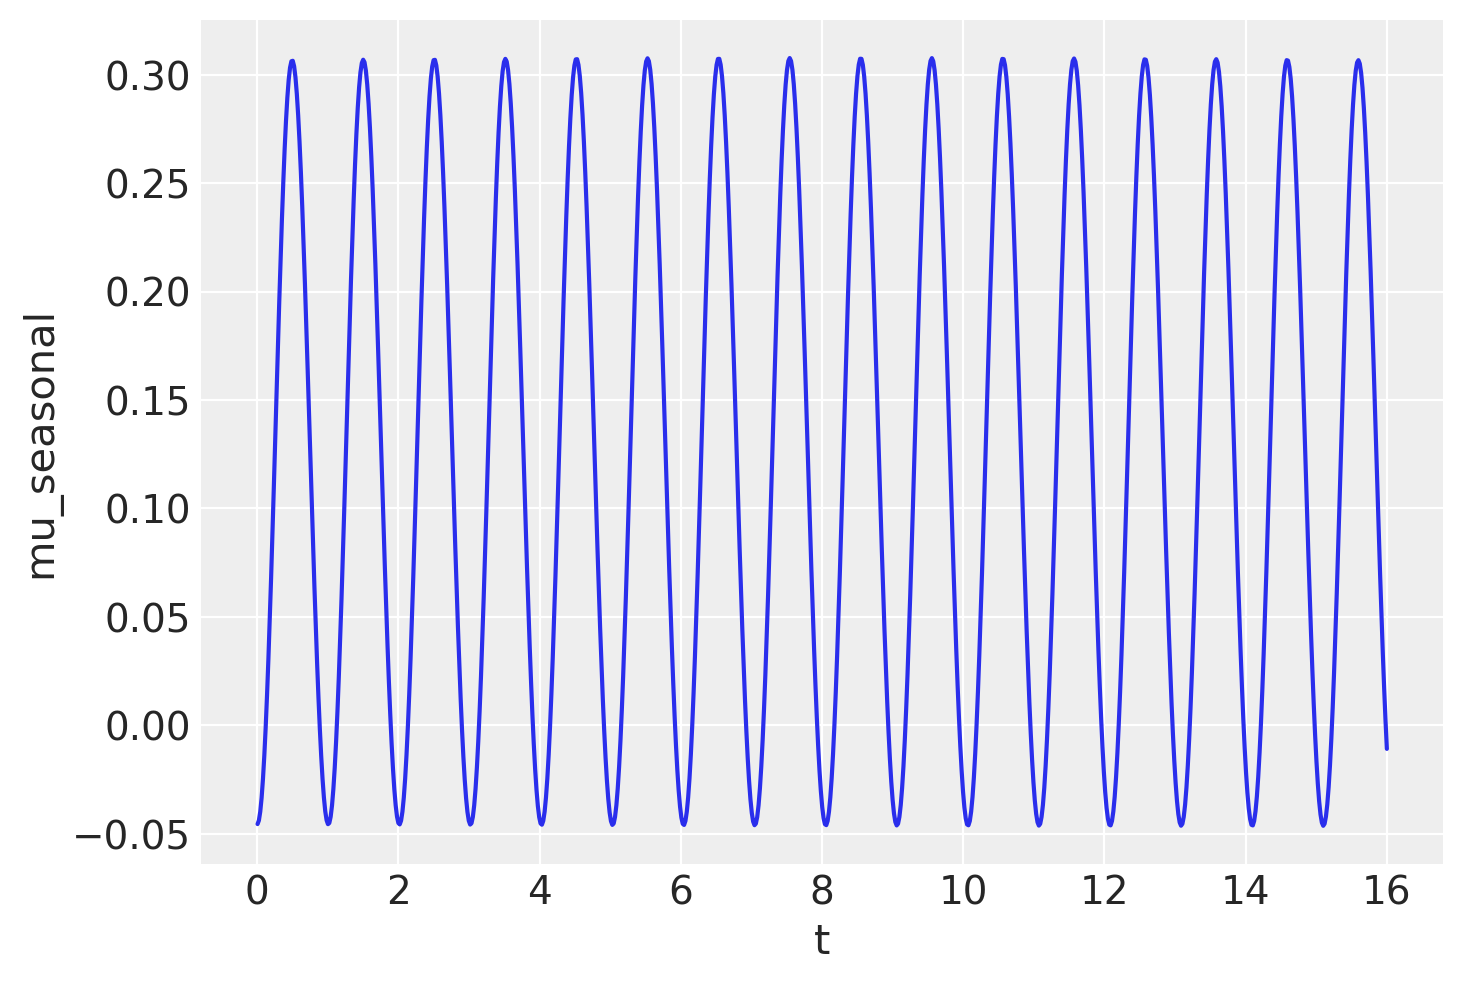

In [295]:
sns.lineplot(data=fit, y='mu_seasonal', x='t')

<AxesSubplot:xlabel='t', ylabel='mu_medium'>

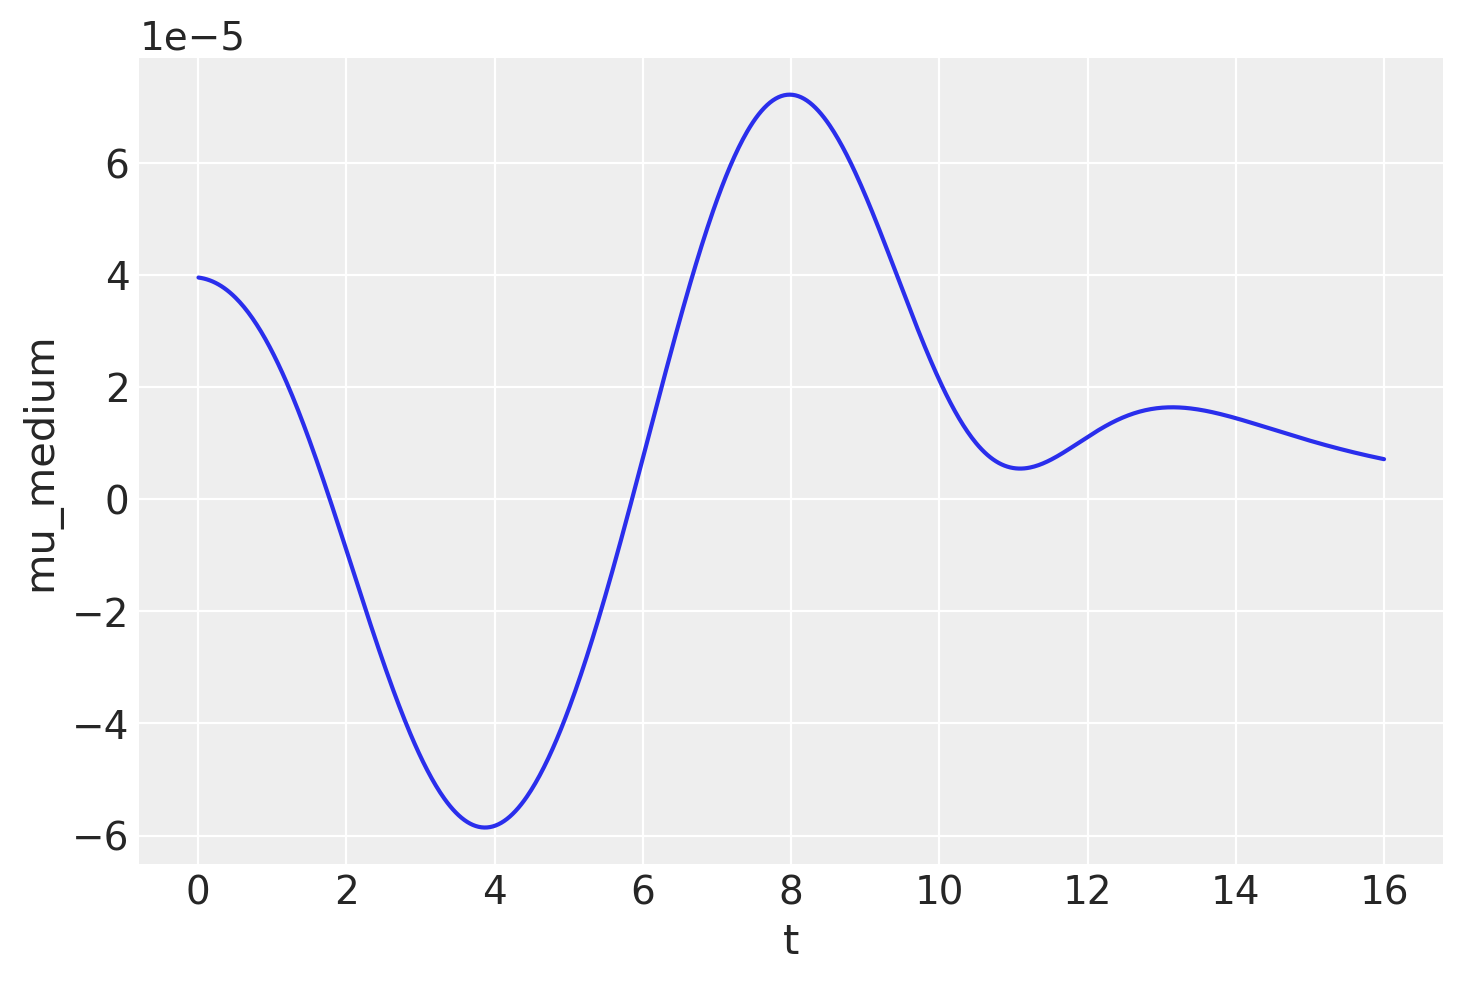

In [296]:
sns.lineplot(data=fit, y='mu_medium', x='t')